## Data Prepare

### data ready

In [1]:
from DataProcess.data_extract import load_all_data, extract_main_tasks, extract_nasatlx_data, extract_dif_conf_data, extract_post_study_responses,extract_quiz_data, normalize_typing_time,split_by_empty_answer,combine_modifying_results
from DataProcess.reading_analysis import annotate_reading, aggregate_reading
from DataProcess.visualization import compare_tasks_across_formats
from DataProcess.parser import run_all_validation
from DataProcess.parse_to_json import CleanJSONParser, CleanXMLParser, CleanYTParser, parse_all_answers
from DataProcess.semantic_evaluate import DeepDiffMetric, TreeEditDistanceMetric, TruthDiffMetric
import json
import pandas as pd

## data folder: config/tabular
folder ='/Users/shiyi.he/Desktop/DSF_Analysis/config'

correct_answers_config = {
    'reading-task-config-1': '7.9.0',
    'reading-task-config-2': ">=12",
    'reading-task-config-3': 6,
    'reading-task-config-4': 'keywords',
    'reading-task-config-5': 'd3-delaunay'
}

correct_answers_tabular = {
    'reading-task-tabular-1': 87,
    'reading-task-tabular-2': 'quiz2',
    'reading-task-tabular-3': 4,
    'reading-task-tabular-4': 'Bob',
    'reading-task-tabular-5': ['[Bob, Alice]', '[Eve]']
}

## read all data from the folder
data = load_all_data(folder, False)

## extract main tasks data
df_reading, df_writing, df_writing_nl, df_modifying = extract_main_tasks(data)

## extract nasatlx, survey, quizdata
df_nasa=extract_nasatlx_data(data)
df_dif_conf = extract_dif_conf_data(data)
df_post =  extract_post_study_responses(data)
quiz_results=extract_quiz_data(data)


### prepare reading result

In [17]:
reading_useful_data=df_reading[['participantId','task','format','answer','duration_sec','help_count','search_count','copy_count','paste_count']]

### result data that we need for reading
reading_result =annotate_reading(
    reading_useful_data,
    correct_answers_config)

reading_aggregated_result = aggregate_reading(reading_result)

reading_result.to_csv('/Users/shiyi.he/Desktop/DSF_Analysis/config_result/reading_result.csv')
reading_aggregated_result.to_csv('/Users/shiyi.he/Desktop/DSF_Analysis/config_result/reading_aggregated_result.csv')

### prepare writing result

In [ ]:
### normalize the typing time
df_writing_norm = normalize_typing_time(df_writing_nl, df_writing)

### run the validation
df_writing_parse_result = run_all_validation(df_writing)


### 把所有的用户答案转换成json格式
parser_json = CleanJSONParser()
parser_xml  = CleanXMLParser()
parser_ytt  = CleanYTParser()
df_writing_parsed = parse_all_answers(df_writing, parser_json, parser_xml, parser_ytt)
df_writing_parsed

## tree similarity analysis
with open('ground_truth_writing_config.json', 'r', encoding='utf-8') as f:  # update the path!!!!!更改路径tabular/config
    ground_truth_writing_config = json.load(f)

w_ts_result = TreeEditDistanceMetric.run_semantic_pipeline(df_writing_parsed, ground_truth_writing_config)
w_ts_result_writing=w_ts_result[['participantId','format','task','tree_similarity']]

### run DeepDiff的结果
import json
gt_path='ground_truth_writing_config.json'     # update the path!!!!!更改路径tabular/config
with open(gt_path) as f:
    G = json.load(f)

w_DD_result=TruthDiffMetric.evaluate_answers_against_truth(G, 
    df_writing_parsed,
    parsed_col="parsed_answer",
    id_col="participantId",
    fmt_col="format")
w_DD_result_writing=w_DD_result[['participantId','format','precision','recall','f1']]
w_DD_result_writing['task']='writing-task-config'  # update the path!!!!!更改路径tabular/config

### merge the result
semantic_merged = w_DD_result_writing.merge(
    w_ts_result_writing[['participantId','format','task','tree_similarity']],
    on=['participantId','format','task'],
    how='left'
)

parse_semantic_merged = semantic_merged.merge(df_writing_parse_result,on=['participantId','format','task'],how='left')

full_merged=parse_semantic_merged.merge(df_writing_norm,on=['participantId','format','task'],how='left')

full_merged.to_csv('/Users/shiyi.he/Desktop/DSF_Analysis/config_result/writing_result.csv')   # update the path!!!!!更改路径tabular/config

,participantId,format,task,tree_similarity
0,5f7f239e9b204e05b6c36538,json5,writing-task-config,0.076923
1,676d220cd6e7101ccba18ba5,jsonc,writing-task-config,0.000000
2,680ebf035ab59d342f31726e,hjson,writing-task-config,0.076923
3,678faf5b31008609fd85b185,json5,writing-task-config,0.086957
4,65e85a421f2dee53c62fbf45,json5,writing-task-config,0.000000
...,...,...,...,...
100,67406c1303bd39d206ff2b50,xml,writing-task-config,0.076923
101,67f66486e35051403284eb5e,xml,writing-task-config,0.076923
102,60f7c71d1cffec381351b0b3,xml,writing-task-config,0.230769
103,5fb4fcd1fce53c30649dd704,xml,writing-task-config,-0.266667


In [2]:
import json
### normalize the typing time
df_writing_norm = normalize_typing_time(df_writing_nl, df_writing)

### run the validation
df_writing_parse_result = run_all_validation(df_writing)


### 把所有的用户答案转换成json格式
parser_json = CleanJSONParser()
parser_xml  = CleanXMLParser()
parser_ytt  = CleanYTParser()
df_writing_parsed = parse_all_answers(df_writing, parser_json, parser_xml, parser_ytt)

## tree similarity analysis
with open('ground_truth_writing_config.json', 'r', encoding='utf-8') as f:  # update the path!!!!!更改路径tabular/config
    ground_truth_writing_config = json.load(f)

w_ts_result = TreeEditDistanceMetric.run_semantic_pipeline(
    df_writing_parsed,
    ground_truth_writing_config
)
w_ts_result_writing=w_ts_result[['participantId','format','task','tree_similarity']]


w_ts_result_writing

,participantId,format,task,tree_similarity
0,5f7f239e9b204e05b6c36538,json5,writing-task-config,0.076923
1,676d220cd6e7101ccba18ba5,jsonc,writing-task-config,0.000000
2,680ebf035ab59d342f31726e,hjson,writing-task-config,0.076923
3,678faf5b31008609fd85b185,json5,writing-task-config,0.086957
4,65e85a421f2dee53c62fbf45,json5,writing-task-config,0.000000
...,...,...,...,...
100,67406c1303bd39d206ff2b50,xml,writing-task-config,0.076923
101,67f66486e35051403284eb5e,xml,writing-task-config,0.076923
102,60f7c71d1cffec381351b0b3,xml,writing-task-config,0.230769
103,5fb4fcd1fce53c30649dd704,xml,writing-task-config,-0.266667


### prepare modifying data

In [ ]:
## 处理空值
modifying_empty, modifying_nonempty = split_by_empty_answer(df_modifying)
modifying_empty['normalized_time']=modifying_empty['duration_sec']

df_modifying_norm=modifying_nonempty[['participantId','format','task','duration_sec','help_count','search_count','copy_count','paste_count']]
df_modifying_norm['normalized_time']=df_modifying_norm['duration_sec']

### run the validation
df_modifying_parse_result = run_all_validation(modifying_nonempty)


### 把所有的用户答案转换成json格式
parser_json = CleanJSONParser()
parser_xml  = CleanXMLParser()
parser_ytt  = CleanYTParser()
df_modifying_parsed = parse_all_answers(modifying_nonempty, parser_json, parser_xml, parser_ytt)

df_modifying_parsed_1 = df_modifying_parsed[df_modifying_parsed['task']=='modifying-task-config-1']
df_modifying_parsed_2 = df_modifying_parsed[df_modifying_parsed['task']=='modifying-task-config-2']
df_modifying_parsed_3 = df_modifying_parsed[df_modifying_parsed['task']=='modifying-task-config-3']
df_modifying_parsed_4 = df_modifying_parsed[df_modifying_parsed['task']=='modifying-task-config-4']


## tree similarity analysis
### task 1

with open('ground_truth_modifying_config_1.json', 'r', encoding='utf-8') as f:  # update the path!!!!!更改路径tabular/config
    ground_truth_modifying_config_1 = json.load(f)

df_modifying_parsed_1 = df_modifying_parsed[df_modifying_parsed['task']=='modifying-task-config-1']
m_1_ts_result = TreeEditDistanceMetric.run_semantic_pipeline(df_modifying_parsed_1, ground_truth_modifying_config_1)
m_1_ts_result_modifying=m_1_ts_result[['participantId','format','task','tree_similarity']]

with open('ground_truth_modifying_config_2.json', 'r', encoding='utf-8') as f:  # update the path!!!!!更改路径tabular/config
    ground_truth_modifying_config_2 = json.load(f)

df_modifying_parsed_2 = df_modifying_parsed[df_modifying_parsed['task']=='modifying-task-config-2']
m_2_ts_result = TreeEditDistanceMetric.run_semantic_pipeline(df_modifying_parsed_2, ground_truth_modifying_config_2)
m_2_ts_result_modifying=m_2_ts_result[['participantId','format','task','tree_similarity']]

with open('ground_truth_modifying_config_3.json', 'r', encoding='utf-8') as f:  # update the path!!!!!更改路径tabular/config
    ground_truth_modifying_config_3 = json.load(f)

df_modifying_parsed_3 = df_modifying_parsed[df_modifying_parsed['task']=='modifying-task-config-3']
m_3_ts_result = TreeEditDistanceMetric.run_semantic_pipeline(df_modifying_parsed_3, ground_truth_modifying_config_3)
m_3_ts_result_modifying=m_3_ts_result[['participantId','format','task','tree_similarity']]

with open('ground_truth_modifying_config_4.json', 'r', encoding='utf-8') as f:  # update the path!!!!!更改路径tabular/config
    ground_truth_modifying_config_4 = json.load(f)

df_modifying_parsed_4 = df_modifying_parsed[df_modifying_parsed['task']=='modifying-task-config-4']
m_4_ts_result = TreeEditDistanceMetric.run_semantic_pipeline(df_modifying_parsed_4, ground_truth_modifying_config_4)
m_4_ts_result_modifying=m_4_ts_result[['participantId','format','task','tree_similarity']]

m_ts_result_modifying=pd.concat([m_1_ts_result_modifying,m_2_ts_result_modifying,m_3_ts_result_modifying,m_4_ts_result_modifying])

### run DeepDiff的结果


prompt_path='prompt_modifying_config.json' # update the path!!!!!更改路径tabular/config
with open(prompt_path) as f:
    P = json.load(f)

gt_path_1='ground_truth_modifying_config_1.json' # update the path!!!!!更改路径tabular/config
with open(gt_path_1) as f:
    G_1 = json.load(f)

gt_path_2='ground_truth_modifying_config_2.json' # update the path!!!!!更改路径tabular/config
with open(gt_path_2) as f:
    G_2 = json.load(f)

gt_path_3='ground_truth_modifying_config_3.json' # update the path!!!!!更改路径tabular/config
with open(gt_path_3) as f:
    G_3 = json.load(f)

gt_path_4='ground_truth_modifying_config_4.json' # update the path!!!!!更改路径tabular/config
with open(gt_path_4) as f:
    G_4 = json.load(f)

m_1_DD_result=DeepDiffMetric.evaluate_answers(P, G_1, df_modifying_parsed_1,ignore_keys=["homepage","collaborators","scripts"]) # update the path!!!!!更改路径tabular/config
m_1_DD_result_modifying=m_1_DD_result[['participantId','format','precision','recall','f1']]
m_1_DD_result_modifying['task']='modifying-task-config-1' # update the path!!!!!更改路径tabular/config

m_2_DD_result=DeepDiffMetric.evaluate_answers(P, G_2, df_modifying_parsed_2,ignore_keys=["homepage","collaborators","scripts"]) # update the path!!!!!更改路径tabular/config
m_2_DD_result_modifying=m_2_DD_result[['participantId','format','precision','recall','f1']]
m_2_DD_result_modifying['task']='modifying-task-config-2' # update the path!!!!!更改路径tabular/config

m_3_DD_result=DeepDiffMetric.evaluate_answers(P, G_3, df_modifying_parsed_3,ignore_keys=["homepage","collaborators","scripts"]) # update the path!!!!!更改路径tabular/config
m_3_DD_result_modifying=m_3_DD_result[['participantId','format','precision','recall','f1']]
m_3_DD_result_modifying['task']='modifying-task-config-3' # update the path!!!!!更改路径tabular/config

m_4_DD_result=DeepDiffMetric.evaluate_answers(P, G_4, df_modifying_parsed_4,ignore_keys=["homepage","collaborators","scripts"]) # update the path!!!!!更改路径tabular/config
m_4_DD_result_modifying=m_4_DD_result[['participantId','format','precision','recall','f1']]
m_4_DD_result_modifying['task']='modifying-task-config-4' # update the path!!!!!更改路径tabular/config

m_DD_result_modifying=pd.concat([m_1_DD_result_modifying,m_2_DD_result_modifying,m_3_DD_result_modifying,m_4_DD_result_modifying])

### merge the result
semantic_merged = m_DD_result_modifying.merge(
    m_ts_result_modifying[['participantId','format','task','tree_similarity']],
    on=['participantId','format','task'],
    how='left'
)

parse_semantic_merged = semantic_merged.merge(df_modifying_parse_result,on=['participantId','format','task'],how='left')

full_merged=parse_semantic_merged.merge(df_modifying_norm,on=['participantId','format','task'],how='left')

df_modifying_all = combine_modifying_results(full_merged, modifying_empty)

df_modifying_all.to_csv('/Users/shiyi.he/Desktop/DSF_Analysis/config_result/modifying_result.csv')   # update the path!!!!!更改路径tabular/config
df_modifying_all

/var/folders/z4/3vn4jgtj71n_hdpgm6b1r_ww0000gp/T/ipykernel_23897/392782550.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_1_DD_result_modifying['task']='modifying-task-config-1' # update the path!!!!!更改路径tabular/config
/var/folders/z4/3vn4jgtj71n_hdpgm6b1r_ww0000gp/T/ipykernel_23897/392782550.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_2_DD_result_modifying['task']='modifying-task-config-2' # update the path!!!!!更改路径tabular/config
/var/folders/z4/3vn4jgtj71n_hdpgm6b1r_ww0000gp/T/ipykernel

### quiz

In [3]:
quiz_results_result=quiz_results[['participantId','format','quiz_key','correct','num_wrong_attempts','duration_sec','wrong_choice_count']]
quiz_results_result.rename(columns={'quiz_key':'task'},inplace=True)
quiz_results_result.to_csv('/Users/shiyi.he/Desktop/DSF_Analysis/config_result/quiz_result.csv')
quiz_results_result

/var/folders/z4/3vn4jgtj71n_hdpgm6b1r_ww0000gp/T/ipykernel_73782/617498263.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quiz_results_result.rename(columns={'quiz_key':'task'},inplace=True)


,participantId,format,task,correct,num_wrong_attempts,duration_sec,wrong_choice_count
0,659960f32faa4ff4b116de92,toml,tutorial-part1,1,4,588.010,5
1,659960f32faa4ff4b116de92,toml,tutorial-part2,1,1,220.866,0
2,5f7f239e9b204e05b6c36538,json5,tutorial-part1,0,5,1135.172,6
3,5f7f239e9b204e05b6c36538,json5,tutorial-part2,1,1,509.298,0
4,676d220cd6e7101ccba18ba5,jsonc,tutorial-part1,0,5,577.648,9
...,...,...,...,...,...,...,...
205,67d24179c5bd87691f1fe036,yaml,tutorial-part2,1,0,46.778,0
206,5c4f5967aac8be0001716a65,xml,tutorial-part1,1,2,119.150,2
207,5c4f5967aac8be0001716a65,xml,tutorial-part2,1,2,105.426,3
208,6680071d60b3642bcf5dad37,jsonc,tutorial-part1,1,3,592.708,3


### nasa

In [5]:
df_nasa_clean=df_nasa[['participantId','format','duration_sec','mental-demand','physical-demand','temporal-demand','performance','frustration','effort']]
df_nasa_clean.to_csv('/Users/shiyi.he/Desktop/DSF_Analysis/config_result/nasa_result.csv')

### post_survey

In [7]:
df_post.to_csv('/Users/shiyi.he/Desktop/DSF_Analysis/config_result/post_result.csv')

### con + diff

In [9]:
df_dif_conf_result=df_dif_conf[['participantId','format','duration_sec','task','confidence','difficulty']]
df_dif_conf_result.to_csv('/Users/shiyi.he/Desktop/DSF_Analysis/config_result/dif_conf_result.csv')
df_dif_conf_result

,participantId,format,duration_sec,task,confidence,difficulty
0,659960f32faa4ff4b116de92,toml,6.977,writing-task-NL,7,1
1,659960f32faa4ff4b116de92,toml,8.721,reading-task-config-1,1,5
2,659960f32faa4ff4b116de92,toml,11.711,reading-task-config-2,5,4
3,659960f32faa4ff4b116de92,toml,9.016,reading-task-config-3,2,4
4,659960f32faa4ff4b116de92,toml,4.735,reading-task-config-4,1,7
...,...,...,...,...,...,...
1150,6680071d60b3642bcf5dad37,jsonc,7.476,writing-task-config,5,4
1151,6680071d60b3642bcf5dad37,jsonc,5.100,modifying-task-config-1,6,2
1152,6680071d60b3642bcf5dad37,jsonc,4.687,modifying-task-config-2,7,1
1153,6680071d60b3642bcf5dad37,jsonc,8.061,modifying-task-config-3,6,3


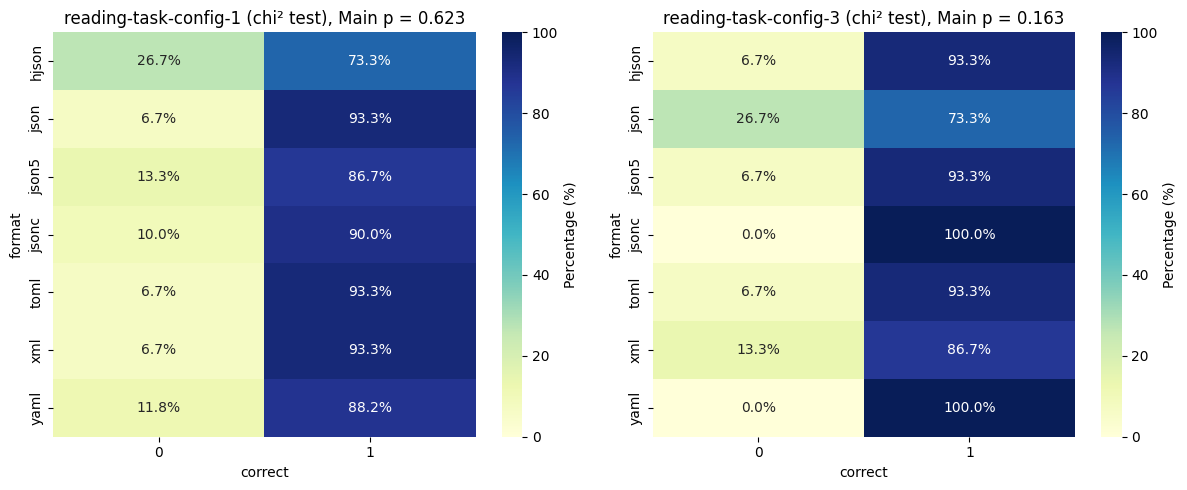

In [2]:
fig, sig_df = compare_tasks_across_formats(
    df=reading_aggregated_result,
    task_list=["reading-task-config-1", "reading-task-config-3"],
    compare_value="correct",   # or "duration_sec"
    data_type="categorical",   # "continuous" or "categorical"
    test_type="auto",          # 推荐保持 auto
    correction_method="holm"
)

In [37]:
import json
row = df_all_0.iloc[1]
print(json.dumps(row['parsed_answer'], ensure_ascii=False, indent=2))

{
  "name": "vega-lite",
  "author": "Dominik Moritz, Kanit Wongs,",
  "version": "5.23.0",
  "collaborators": [
    "Kanit Wongsuphasawat",
    "Dominik Moritz",
    "Arvind Satyanarayan",
    "Jeffrey Heer"
  ],
  "homepage": "vega.github.io/vega-lite/",
  "description": "Vega-Lite is a concise high-level language for interactive visualization.",
  "keywords": [
    "vega",
    "chart",
    "visualization"
  ],
  "main": "build/vega-lite.js",
  "unpkg": "build/vega-lite.min.js",
  "jsdelivr": "build/vega-lite.min.js",
  "module": "build/src/index",
  "types": "build/src/index.d.ts",
  "files": [
    "bin",
    "build",
    "src",
    "vega-lite*",
    "tsconfig.json"
  ],
  "license": "BSD-3-Clause",
  "packageManager": "yarn@1.22.22",
  "bin": {
    "vl2pdf": "./bin/vl2pdf",
    "vl2png": "./bin/vl2png",
    "vl2svg": "./bin/vl2svg",
    "vl2vg": "./bin/vl2vg"
  },
  "scripts": {
    "changelog": "conventional-changelog -p angular -r",
    "prebuild": "yarn clean:build",
    "build"